# Approximate Inference in Bayesian Deep Learning: Getting Started in Pytorch

In this colab we will walk you through downloading the data, running your method and generating a submission for our NeurIPS 2021 competition. In this colab we use the Pytorch framework. For Jax see [this notebook](https://colab.research.google.com/drive/1SJ6waN8DOfby6qW9WWgJ0VLyaNzauhYD?usp=sharing).

Useful references:
- [Competition website](https://izmailovpavel.github.io/neurips_bdl_competition/)
- [Efficient implementation of several baselines in JAX](https://github.com/google-research/google-research/tree/master/bnn_hmc)
- [Submission platform](https://competitions.codalab.org/competitions/33647)


## Setting up colab

Colab provides an easy-to-use environment for working on the competition with access to free computational resources. However, you should also be able to run this notebook locally after installing the required dependencies. If you use colab, please select a `GPU` runtime type.

## Preparing the data


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

print(os.getcwd())
os.chdir("/content/drive/MyDrive/neurips_bdl_sirius2021")
print(os.getcwd())

/content
/content/drive/MyDrive/neurips_bdl_sirius2021


In [3]:
import sys
import math
import matplotlib
import numpy as np
import copy

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

sys.path.append("neurips_bdl_starter_kit")
import pytorch_models as p_models
from loss_function import log_posterior_fn
from eval import get_accuracy_fn, evaluate_fn
from data_loading import safe_load_numpy, NormClfDataset
from vram_stats import get_vram_usage_str
import importlib
import swag
import averaging

We provide the datasets used in this competition in a public Google Cloud Storage bucket in the `.csv` format. Here we download the data:

You can also download the data to your computer by clicking these links:
- [CIFAR-10 train features](https://storage.googleapis.com/neurips2021_bdl_competition/cifar10_train_x.csv)
- [CIFAR-10 train labels](https://storage.googleapis.com/neurips2021_bdl_competition/cifar10_train_y.csv)
- [CIFAR-10 test features](https://storage.googleapis.com/neurips2021_bdl_competition/cifar10_test_x.csv)
- [CIFAR-10 test labels](https://storage.googleapis.com/neurips2021_bdl_competition/cifar10_test_y.csv)

In [4]:
#!gsutil -m cp -r gs://neurips2021_bdl_competition/cifar10_*.csv .

We can now read the data and convert it into numpy arrays. This cell may take several minutes to run.

In [5]:
x_train = safe_load_numpy("cifar10_train_x")
y_train = safe_load_numpy("cifar10_train_y")
x_test = safe_load_numpy("cifar10_test_x")
y_test = safe_load_numpy("cifar10_test_y")

In [6]:
# Split for validation
train_size = 0.9
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=train_size, stratify=y_train)

In [7]:
x_train = x_train.reshape((len(x_train), 32, 32, 3))
x_test = x_test.reshape((len(x_test), 32, 32, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


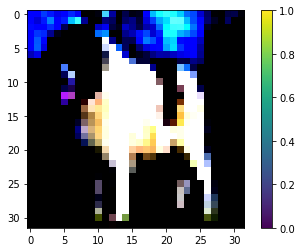

In [8]:
plt.imshow(x_train[0].reshape(32, 32, 3))
plt.colorbar()

Finally, we define a `torch.utils.data.TensorDataset` for the train and test datasets.

In [9]:
trainset = NormClfDataset(x_train, y_train)
testset = NormClfDataset(x_test, y_test)

## Model and losses

We provide the code for all the models used in the competition in the `neurips_bdl_starter_kit/torch_models.py` module. Here, we will load a ResNet-20 model with filter response normalization (FRN) and swish activations. The models are implemented in `pytorch`. 

We also define the cross-entropy likelihood (`log_likelihood_fn`) and Gaussian prior (`log_prior_fn`), and the corresponding posterior log-density (`log_posterior_fn`). The `log_posterior_wgrad_fn` computes the posterior log-density and its gradients with respect to the parameters of the model.

The `evaluate_fn` function computes the accuracy and predictions of the model on a given dataset; we will use this function to generate the predictions for our submission.

In [10]:
!nvidia-smi

Tue Aug  3 19:52:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    38W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
net_fn =  p_models.get_model("resnet20_frn_swish", data_info={"num_classes": 10})
if torch.cuda.is_available():
    print("GPU available!")
    net_fn = net_fn.cuda()

GPU available!


## Optimization and training 

In this colab we train an approximate maximum-a-posteriori (MAP) solution as our submission for simplicity. You can find efficient implementations of more advanced baselines in jax [here](https://github.com/google-research/google-research/tree/master/bnn_hmc).

We use SGD with momentum. You can adjust the hyper-parameters or switch to a different optimizer by changing the code below.

We run training for 5 epochs, which can take several minutes to complete. Note that in order to achieve good results you need to run the method substantially longer and tune the hyper-parameters.

In [12]:
batch_size = 256
test_batch_size = 100
num_epochs = 1
momentum_decay = 0.8
lr = 0.001

prior_variance = 5.

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=test_batch_size, shuffle=False)

In [13]:
epoch_steps = len(train_loader)

#optimizer = optim.SGD(net_fn.parameters(), lr=lr, momentum=momentum_decay)
optimizer = optim.Adam(net_fn.parameters(), lr=lr)
#scheduler = CyclicLR(optimizer, base_lr=0.0001, max_lr=0.0005)

for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    total_loss = 0.0
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        loss = - log_posterior_fn(net_fn, data, prior_variance)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        total_loss += loss.item()

        train_accuracy_batch, _ = get_accuracy_fn(net_fn, data)

        if i % 10 == 0:    # print every 100 mini-batches
            print(f'[{epoch:3d}, {i + 1:5d}] loss: {running_loss/10:16.3f} acc: {train_accuracy_batch:.2f}')
            running_loss = 0.0

    #scheduler.step()    
    print("Epoch {}".format(epoch+1))
    print("\tAverage loss: {}".format(total_loss / epoch_steps))
    print("\tTrain accuracy batch: {}".format(train_accuracy_batch))
    if epoch % 4 == 0:
        test_acc, all_test_probs_1 = evaluate_fn(net_fn, test_loader)
        print("\tTest accuracy: {}".format(test_acc))
        print(get_vram_usage_str())
torch.save(net_fn.state_dict(), "lr_0008_md_8.pth")

[  1,     1] loss:        48528.500 acc: 0.11
[  1,    11] loss:       485186.725 acc: 0.14
[  1,    21] loss:       485147.112 acc: 0.23
[  1,    31] loss:       485137.291 acc: 0.22
[  1,    41] loss:       485118.622 acc: 0.24
[  1,    51] loss:       485102.397 acc: 0.30
[  1,    61] loss:       485086.516 acc: 0.30
[  1,    71] loss:       485078.616 acc: 0.35
[  1,    81] loss:       485072.659 acc: 0.28
[  1,    91] loss:       485060.756 acc: 0.36
[  1,   101] loss:       485049.175 acc: 0.41
[  1,   111] loss:       485031.400 acc: 0.46
[  1,   121] loss:       485023.278 acc: 0.41
[  1,   131] loss:       485021.859 acc: 0.35
[  1,   141] loss:       485019.138 acc: 0.43
[  1,   151] loss:       485002.175 acc: 0.41
[  1,   161] loss:       484994.847 acc: 0.40
[  1,   171] loss:       484994.147 acc: 0.40
Epoch 2
	Average loss: 485064.9549005682
	Train accuracy batch: 0.41999998688697815


In [14]:
# torch.save(net_fn.state_dict(), "moment_95.pth")

# net_fn.load_state_dict(torch.load("moment_95.pth"))
# net_fn.eval()

# model_state_dict = copy.deepcopy(net_fn.state_dict())

train_acc, all_train_probs = evaluate_fn(net_fn, train_loader, None)
print("\tTrain accuracy: {}".format(train_acc))
test_acc, all_test_probs = evaluate_fn(net_fn, test_loader, None)
print("\tTest accuracy: {}".format(test_acc))

	Train accuracy: 0.41339399851858616
	Test accuracy: 0.41469999015331266


In [15]:
import swag
#importlib.reload(swag)


# T = 200
# batch_size = 100

# teta, diag, D = swag.train_SWAG(net_fn, log_posterior_fn, trainset, T, batch_size)
T = 800
batch_size = 100

teta, teta_sqr, D = swag.train_SWAG(net_fn, log_posterior_fn, trainset, T, 
                                    batch_size, c=20, K=20)

<class 'function'>


In [16]:
import averaging
#importlib.reload(averaging)

S = 10
diag = teta_sqr
all_test_probs = averaging.average_models(net_fn, test_loader, teta, diag, D, S)

In [17]:
all_test_probs_np = np.asarray(all_test_probs.cpu())

## Evaluating metrics

The starter kit comes with a script that can compute the agreement and total variation distance metrics used in the competition.

In [18]:
import metrics

We can load the HMC reference predictions from the starter kit as well.

In [19]:
with open('data/cifar10/probs.csv', 'r') as fp:
  reference = np.loadtxt(fp)

Now we can compute the metrics!

In [20]:
from sklearn.metrics import accuracy_score

swag_point = np.argmax(all_test_probs_np, axis=-1)
acc = accuracy_score(swag_point, y_test)
agree = metrics.agreement(all_test_probs_np, reference)
tvd = metrics.total_variation_distance(all_test_probs_np, reference)

print(f"SWAG \t Acc: {acc:.2f} \t Agreement: {agree:.2f} \t TV distance: {tvd:.2f}")

SWAG 	 Acc: 0.37 	 Agreement: 0.37 	 TV distance: 0.70


## Preparing the submission

Once you run the code above, `all_test_probs` should contain an array of size `10000 x 10` where the rows correspond to test datapoints and columns correspond to classes.

In [21]:
all_test_probs.shape

torch.Size([10000, 10])

Now, we need to save the array as `cifar10_probs.csv` and create a zip archive with this file.

In [22]:
np.savetxt("cifar10_probs.csv", all_test_probs_np)

!zip submission.zip cifar10_probs.csv

updating: cifar10_probs.csv (deflated 57%)


Finally, you can download the submission by running the code below. If the download doesn't start, check that your browser did not block it automatically.

In [23]:
from google.colab import files
files.download('submission.zip') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Now you can head over to the [submission system](https://competitions.codalab.org/competitions/33512?secret_key=10f23c1f-9c86-4a7a-8406-d85b0a0713f2#participate) and upload your submission. Good luck :)